### CIR model for interest rates and liability hedging
- Cox Ingersoll Ross model is used to model dynamics of interest rates
- It is an extension of basic Vasicek Model to prevent negative interest rates

In [1]:
import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload
%autoreload 2
%matplotlib inline
import risk_kit as rk
import pandas as pd
import numpy as np
import matplotlib as plt

In [3]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized to a short rate
    """
    return np.log1p(r)

In [14]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, 
        steps_per_year=12, r_0=None):
    """Implements the CIR model"""
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1 / steps_per_year
    
    num_steps = int(n_years * steps_per_year) + 1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    for step in range(1, num_steps):
        r_t = rates[step - 1]
        d_r_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

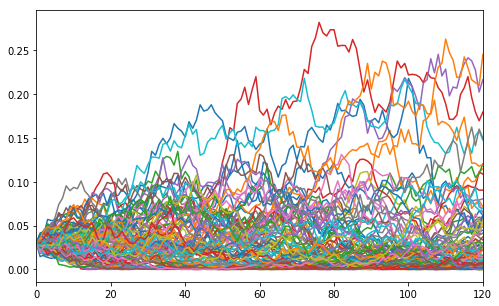

In [16]:
cir(n_scenarios=100, sigma=0.1).plot(figsize=(8,5), legend=False)

In [55]:
def show_cir_prices(r_0=0.03, a=0.05, b=0.03, sigma=0.05, n_scenarios=5):
    rk.cir(r_0=r_0, a=a, b=b, sigma=sigma,
        n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(8,5))
    
controls = widgets.interactive(show_cir_prices,
                              r_0=(0, 0.15, 0.01),
                              a=(0, 1, 0.1),
                              b=(0, 0.15, 0.01),
                              sigma=(0, 0.1, 0.01),
                              n_scenarios=(0, 100))

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.05,…

In [62]:
a_0 = 750000 # asset 
rates, bond_prices = rk.cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)

In [63]:
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = rk.pv(zcbond_10, r=0.03)

In [74]:
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (rates/12 + 1).cumprod()

In [75]:
av_zc_bonds.head()

,0,1,2,3,4,5,6,7,8,9
0,755539.951942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,734780.225274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,727361.482505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,741647.249390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,731846.700130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


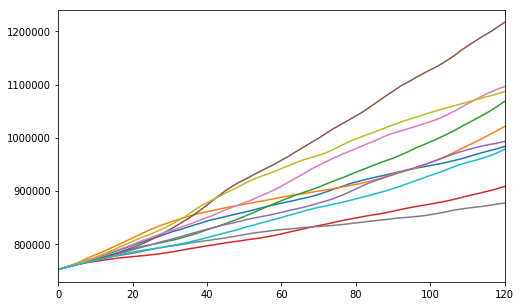

In [66]:
av_cash.plot(legend=False, figsize=(8, 5))

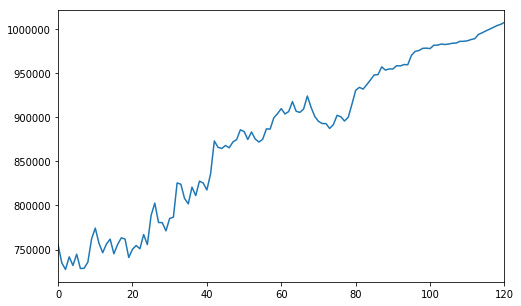

In [67]:
av_zc_bonds.plot(legend=False, figsize=(8, 5))

In [80]:
#rk.discount(30, 0.01)
50* 1.03**(-20)

27.683787709316725

In [86]:
(411681 / 7257519) #* 1700000

0.05672475676605187

In [88]:
2000000 * 0.05

100000.0

In [89]:
110000 / 1750123

0.06285272520845678

### Monte Carlo Sims of Bond Prices with Cox-Ingersoll-Ross

In [4]:
rk.bond_price(5, 100, 0.05, 12, 0.03)

0    109.275393
dtype: float64

In [9]:
rates, zc_prices = rk.cir(10, 500, b=0.03, r_0=0.03)

In [11]:
rk.bond_price(5, 100, 0.05, 12, rates.iloc[1][[1,2,3]])

1    109.128559
2    108.804769
3    109.381164
dtype: float64

In [13]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.030302,0.030969,0.029783
2,0.028024,0.027171,0.029822
3,0.026947,0.027484,0.031947
4,0.026384,0.030952,0.030855


### Homework #4

B1 is a 15 Year Bond with a Face Value of $1000 that pays 
a 5% coupon semi-annually (2 times a year)

B2 is a 5 Year Bond with a Face value of $1000 that pays a 6% coupon quarterly (4 times a year)

B3 is a 10 Year Zero-Coupon Bond with a Face Value of $1000 


(Hint: you can still use the erk.bond_cash_flows() and erk.bond_price() by setting the coupon amount to 0% and coupons_per_year to 1) Assume the yield curve is flat at 5%. 

In [5]:
rk.bond_price(15, 1000, 0.05, 2, 0.05)

0    1000.0
dtype: float64

In [6]:
rk.bond_price(5, 1000, 0.06, 4, 0.05)

0    1043.99829
dtype: float64

In [7]:
rk.bond_price(10, 1000, 0, 1, 0.05)

0    613.913254
dtype: float64

What is the price of the 10 Year Zero Coupon Bond B3?

Duration refers to Macaulay Duration
Hint: the macaulay_duration function gives as output the duration expressed in periods and not in years. If you want to get the yearly duration you need to divide the duration for coupons_per_year; e.g.: duarion_B2 = erk.macaulay_duration(flows_B2, 0.05/4)/4

In [28]:
b1_flows = rk.bond_cash_flows(15, 1000, 0.05, 2)
rk.macaulay_duration(b1_flows, 0.05/2)/2

10.72677495379012

In [29]:
b2_flows = rk.bond_cash_flows(5, 1000, 0.06, 4)
rk.macaulay_duration(b2_flows, 0.05/4)/4

4.373363222636413

In [30]:
b3_flows = rk.bond_cash_flows(10, 1000, 0, 1)
rk.macaulay_duration(b3_flows, 0.05)/1

10.0

Assume a sequence of 3 liabilities of $100,000, $200,000 and $300,000 that are 3, 5 and 10 years away, respectively. What is the Duration of the liabilities?

(Reminder: Assume the yield curve is flat at 5%. Duration refers to Macaulay Duration)

In [27]:
liabilities = pd.DataFrame(data=[100000, 200000, 300000], index=[3, 5, 10])
rk.macaulay_duration(liabilities, 0.05)

6.750917852744651

Assuming the same liabilities as the previous questions (i.e. a sequence of 3 liabilities of
                                                        $100,000, $200,000 and $300,000 that are 3, 5 and 10 years away, respectively), build a Duration Matched Portfolio of B2 and B3 to match the liabilities.

What is the weight of B2 in this portfolio?

In [36]:
liabs = pd.Series(data=[100000, 200000, 300000], index=[3, 5, 10])

b1 = rk.bond_cash_flows(15, 1000, coupon_rate=0.05, coupons_per_year=1)

b2 = rk.bond_cash_flows(5, 1000, coupon_rate=0.06, coupons_per_year=1)

ws = rk.match_durations(liabs, b1, b2, 0.05)

In [38]:
ws.all()

True

In [40]:
b3 = rk.bond_cash_flows(10, 1000, 0, 1)
b3

1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10    1000.0
dtype: float64